# Experimental portfolio
The work plan is
1. Download some assets' stock price data: NVDA, GOOGL, CSSPX.MI, UCG.MI, ISP.MI, CSSX5E.MI
2. Download EURUSD=X exchange rate
3. Convert stocks' dollar prices to euro
4. Plot stocks' prices in €
5. Simple moving averages for NVDA and crossover trading strategy 
6. Calculate the returns
7. Set the assets' weights in the portfolio
8. Calculate the portfolio mean return
9. Calculate the portfolio covariance matrix

In [2]:
# Core numerical computing
import numpy as np
import pandas as pd

# For financial data
import yfinance as yf       # Loading financial data

# Plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_theme(style="darkgrid")

import warnings
warnings.filterwarnings('ignore')
print('NumPy version: {}'.format(np.__version__))
print('Pandas version: {}'.format(pd.__version__))
print('Seaborn version: {}'.format(sns.__version__))
print('YFinance version: {}'.format(yf.__version__))

NumPy version: 1.26.4
Pandas version: 2.2.2
Seaborn version: 0.13.2
YFinance version: 0.2.65


## 1. Downloading the stock prices
We download the price time series for a number of stocs. The NVDA and GOOGL prices are in USD, the others in EUR.

In [82]:
start_day = '2024-01-01'
end_day = '2025-10-13'
date_index = pd.date_range(start_day, end_day)

In [15]:
stocks_list = ['NVDA', 'GOOGL', 'CSSPX.MI', 'UCG.MI', 'ISP.MI']
stocks = yf.download(stocks_list, start=start_day, end=end_day)

[*********************100%***********************]  5 of 5 completed


In [25]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 460 entries, 2024-01-02 to 2025-10-10
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   (Close, CSSPX.MI)   451 non-null    float64
 1   (Close, GOOGL)      446 non-null    float64
 2   (Close, ISP.MI)     451 non-null    float64
 3   (Close, NVDA)       446 non-null    float64
 4   (Close, UCG.MI)     451 non-null    float64
 5   (High, CSSPX.MI)    451 non-null    float64
 6   (High, GOOGL)       446 non-null    float64
 7   (High, ISP.MI)      451 non-null    float64
 8   (High, NVDA)        446 non-null    float64
 9   (High, UCG.MI)      451 non-null    float64
 10  (Low, CSSPX.MI)     451 non-null    float64
 11  (Low, GOOGL)        446 non-null    float64
 12  (Low, ISP.MI)       451 non-null    float64
 13  (Low, NVDA)         446 non-null    float64
 14  (Low, UCG.MI)       451 non-null    float64
 15  (Open, CSSPX.MI)    451 non-null    fl

In [16]:
stocks.head(3)

Price            Close                                              \
Ticker        CSSPX.MI       GOOGL    ISP.MI       NVDA     UCG.MI   
Date                                                                 
2024-01-02  454.119995  137.223557  2.388138  48.143856  22.524326   
2024-01-03  452.890015  137.968430  2.385922  47.545158  22.362345   
2024-01-04  451.850006  135.455750  2.441316  47.973949  23.050762   

Price             High                                              ...  \
Ticker        CSSPX.MI       GOOGL    ISP.MI       NVDA     UCG.MI  ...   
Date                                                                ...   
2024-01-02  455.089996  138.494788  2.391240  49.270290  22.825790  ...   
2024-01-03  454.750000  138.673573  2.408080  48.159848  22.686305  ...   
2024-01-04  452.440002  138.206780  2.441316  48.475697  23.050762  ...   

Price             Open                                               Volume  \
Ticker        CSSPX.MI       GOOGL    ISP.MI       NVDA     UCG.MI CSSPX.MI   
Date                                                                          
2024-01-02  454.589996  137.600958  2.350470  49.219317  22.182366   9023.0   
2024-01-03  453.910004  136.309870  2.393012  47.461201  22.551321   6664.0   
2024-01-04  452.179993  137.471843  2.392569  47.743062  22.398339   2129.0   

Price                                                         
Ticker           GOOGL       ISP.MI         NVDA      UCG.MI  
Date                                                          
2024-01-02  23711200.0   87894747.0  411254000.0   8983858.0  
2024-01-03  24212100.0   76756319.0  320896000.0   7414207.0  
2024-01-04  27137700.0  106214744.0  306535000.0  11296542.0  

[3 rows x 25 columns]

In [17]:
stocks.tail(3)

Price            Close                                                  High  \
Ticker        CSSPX.MI       GOOGL ISP.MI        NVDA     UCG.MI    CSSPX.MI   
Date                                                                           
2025-10-08  621.200012  244.619995  5.542  189.110001  64.430000  621.299988   
2025-10-09  622.099976  241.529999  5.508  192.570007  63.509998  623.059998   
2025-10-10  609.840027  236.570007  5.430  183.160004  62.400002  625.000000   

Price                                                 ...        Open  \
Ticker           GOOGL ISP.MI        NVDA     UCG.MI  ...    CSSPX.MI   
Date                                                  ...               
2025-10-08  246.009995  5.569  189.600006  64.470001  ...  618.369995   
2025-10-09  244.759995  5.565  195.300003  64.080002  ...  621.950012   
2025-10-10  244.089996  5.563  195.619995  64.120003  ...  622.780029   

Price                                                  Volume              \
Ticker           GOOGL ISP.MI        NVDA     UCG.MI CSSPX.MI       GOOGL   
Date                                                                        
2025-10-08  244.960007  5.502  186.570007  63.200001  13938.0  21307100.0   
2025-10-09  244.470001  5.542  192.229996  64.029999   9751.0  27892100.0   
2025-10-10  241.429993  5.511  193.509995  63.480000  45558.0  33180300.0   

Price                                           
Ticker          ISP.MI         NVDA     UCG.MI  
Date                                            
2025-10-08  40154880.0  130168900.0  4195946.0  
2025-10-09  35864943.0  182997200.0  4987943.0  
2025-10-10  48222876.0  268774400.0  4334925.0  

[3 rows x 25 columns]

In [18]:
stocks_close = stocks['Close']
stocks_close.head()

Ticker,CSSPX.MI,GOOGL,ISP.MI,NVDA,UCG.MI
Date,,,,,
2024-01-02,454.119995,137.223557,2.388138,48.143856,22.524326
2024-01-03,452.890015,137.968430,2.385922,47.545158,22.362345
2024-01-04,451.850006,135.455750,2.441316,47.973949,23.050762
2024-01-05,450.420013,134.800262,2.470564,49.072395,23.208246
2024-01-08,451.420013,137.888977,2.477654,52.226810,23.388224


In [21]:
portfolio_price_file = '../data/portfolio_price_data.csv'
stocks_close.to_csv(portfolio_price_file)

## 2. Downloading EURUSD=X exchange rates

In [22]:
eur_usd = yf.download('EURUSD=X', start='2024-01-01', end='2025-10-13')
eur_usd.tail(3)

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,EURUSD=X,EURUSD=X,EURUSD=X,EURUSD=X,EURUSD=X
Date,,,,,
2025-10-08,1.165460,1.165297,1.160362,1.165460,0
2025-10-09,1.163196,1.164958,1.154921,1.163196,0
2025-10-10,1.156644,1.162994,1.156083,1.156644,0


In [23]:
eur_usd_close = eur_usd['Close']
eur_usd_close.tail(3)

Ticker,EURUSD=X
Date,
2025-10-08,1.165460
2025-10-09,1.163196
2025-10-10,1.156644


In [28]:
eur_usd_close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 462 entries, 2024-01-01 to 2025-10-10
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   EURUSD=X  462 non-null    float64
dtypes: float64(1)
memory usage: 7.2 KB


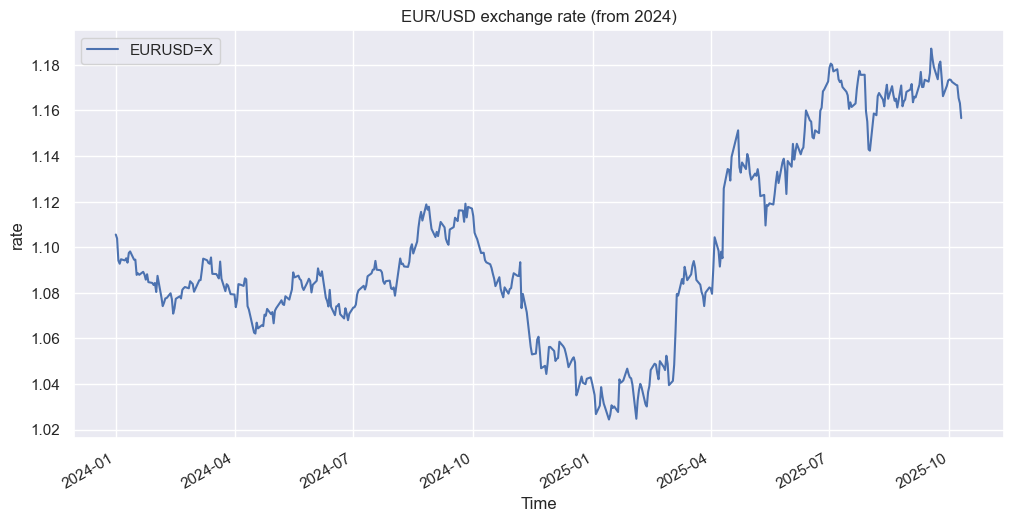

In [27]:
fig, ax = plt.subplots(figsize=(12, 6))
eur_usd_close.plot(ax=ax)
ax.set_title('EUR/USD exchange rate (from 2024)')
ax.set_xlabel('Time')
ax.set_ylabel('rate')
ax.legend(title="")
plt.show()

In [24]:
eur_usd_file = '../data/eur_usd_data.csv'
eur_usd_close.to_csv(eur_usd_file)

## 3. Converting stocks' dollar prices to euro

In [105]:
stocks_close['NVDA_EUR'] = np.nan
stocks_close['GOOGL_EUR'] = np.nan
for day in date_index:
    day_key = str(day.date())
    if ((day_key in stocks_close.index) and (day_key in eur_usd_close.index)):
        nvda_usd_price = stocks_close['NVDA'][day_key]
        googl_usd_price = stocks_close['GOOGL'][day_key]
        eur_usd = eur_usd_close['EURUSD=X'][day_key]
        nvda_eur_price = nvda_usd_price / eur_usd
        stocks_close['NVDA_EUR'][day_key] = nvda_eur_price
        googl_eur_price = googl_usd_price / eur_usd
        stocks_close['GOOGL_EUR'][day_key] = googl_eur_price

In [109]:
stocks_close_eur = stocks_close.drop(['NVDA', 'GOOGL'], axis=1)
stocks_close_eur.head()

Ticker,CSSPX.MI,ISP.MI,UCG.MI,NVDA_EUR,GOOGL_EUR
Date,,,,,
2024-01-02,454.119995,2.388138,22.524326,43.613521,124.310824
2024-01-03,452.890015,2.385922,22.362345,43.452947,126.093488
2024-01-04,451.850006,2.441316,23.050762,43.900960,123.955553
2024-01-05,450.420013,2.470564,23.208246,44.825669,123.134644
2024-01-08,451.420013,2.477654,23.388224,47.729559,126.015354


## 4. Plot stocks' prices in €

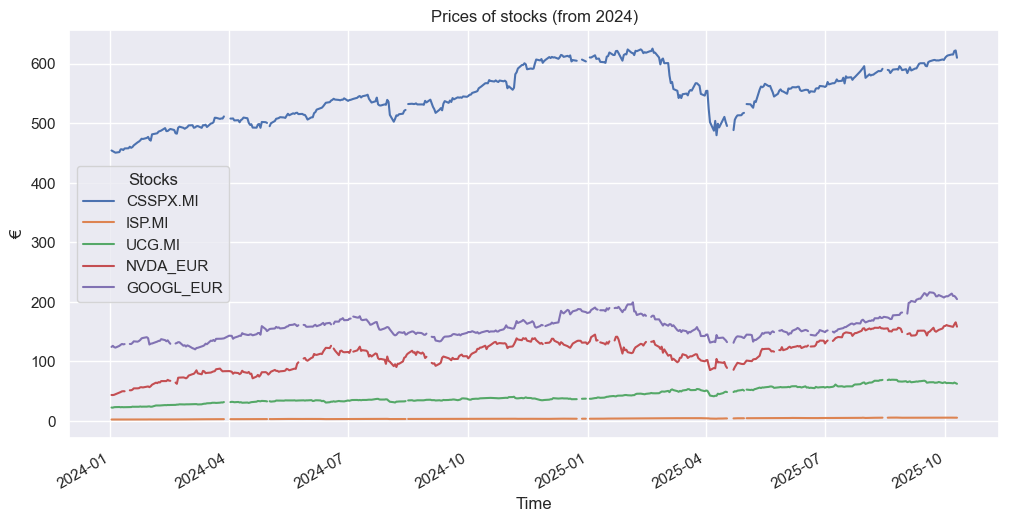

In [111]:
fig, ax = plt.subplots(figsize=(12, 6))
stocks_close_eur.plot(ax=ax)
ax.set_title('Prices of stocks (from 2024)')
ax.set_xlabel('Time')
ax.set_ylabel('€')
ax.legend(title="Stocks")
plt.show()

## 5. NVDA moving averages an crossover trading strategy

In [119]:
stocks_close_eur['NVDA_EUR'].isna().any()

True

In [120]:
sym = 'NVDA_EUR'
nvda_eur = pd.DataFrame(stocks_close_eur[sym]).dropna()
nvda_eur.tail()

,NVDA_EUR
Date,
2025-10-06,158.412191
2025-10-07,158.014904
2025-10-08,162.262063
2025-10-09,165.552438
2025-10-10,158.354644


In [121]:
window = 20  
nvda_eur['mean'] = nvda_eur[sym].rolling(window=window).mean()  
nvda_eur['std'] = nvda_eur[sym].rolling(window=window).std()
nvda_eur['median'] = nvda_eur[sym].rolling(window=window).median()
nvda_eur['min'] = nvda_eur[sym].rolling(window=window).min()  
nvda_eur['max'] = nvda_eur[sym].rolling(window=window).max()  
nvda_eur.dropna().head()

,NVDA_EUR,mean,std,median,min,max
Date,,,,,,
2024-01-30,57.910104,51.302562,4.840766,51.491999,43.452947,57.910104
2024-01-31,56.712990,51.957535,4.627145,51.966566,43.452947,57.910104
2024-02-01,58.307920,52.700284,4.375559,53.545023,43.900960,58.307920
2024-02-02,60.808263,53.545649,4.216404,54.697910,44.825669,60.808263
2024-02-05,64.282916,54.518511,4.341384,54.870694,47.729559,64.282916


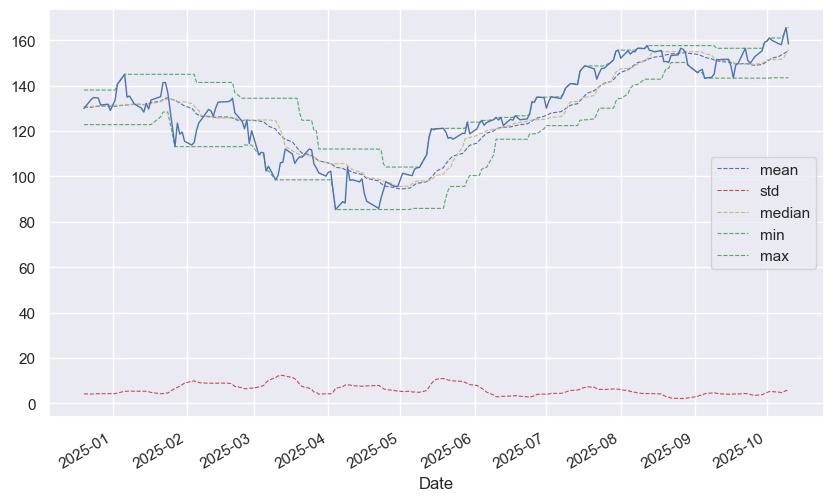

In [122]:
ax = nvda_eur[['mean', 'std', 'median', 'min', 'max']].iloc[-200:].plot(figsize=(10, 6), style=['b--', 'r--', 'y--', 'g--', 'g--'], lw=0.8)  
nvda_eur[sym].iloc[-200:].plot(ax=ax, lw=1.0); 

In [123]:
nvda_eur['SMA_Short_term'] = nvda_eur[sym].rolling(window=50).mean()
nvda_eur['SMA_Long_term'] = nvda_eur[sym].rolling(window=200).mean()

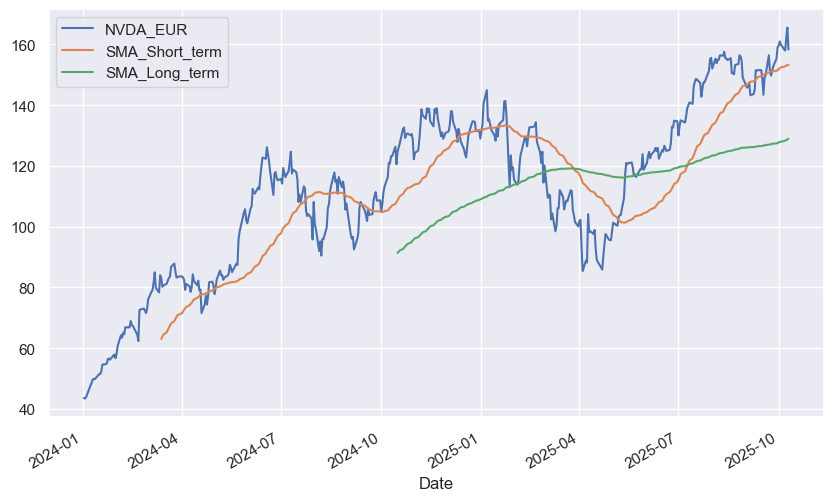

In [124]:
nvda_eur[[sym, 'SMA_Short_term', 'SMA_Long_term']].plot(figsize=(10, 6));  

We add the intervals where there is a crossover, that is where the short-term SMA lies above the long-term SMA to the data frame. We use 1 for the long position (buy) and -1 for the short one (sell).

In [125]:
nvda_eur.dropna(inplace=True)
nvda_eur['positions'] = np.where(nvda_eur['SMA_Short_term'] > nvda_eur['SMA_Long_term'], 1, -1) 

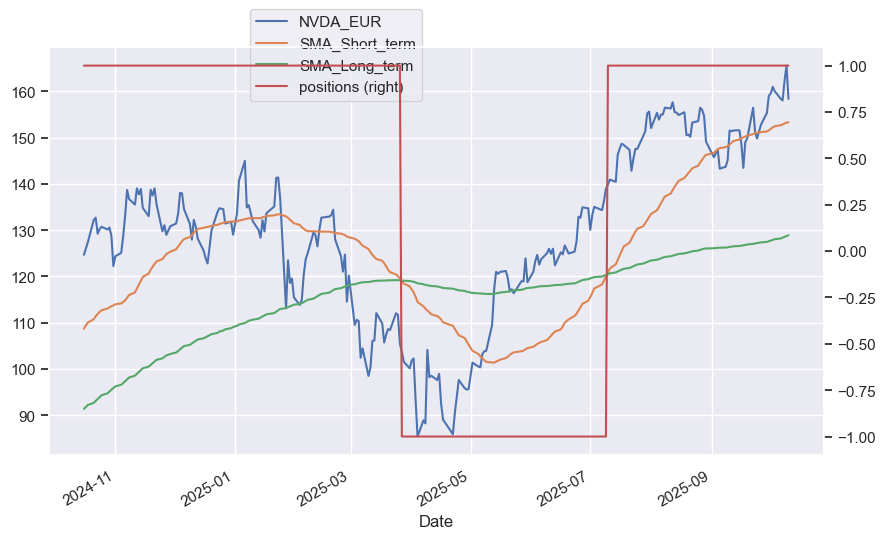

In [126]:
ax = nvda_eur[[sym, 'SMA_Short_term', 'SMA_Long_term', 'positions']].plot(figsize=(10, 6), secondary_y='positions')
ax.get_legend().set_bbox_to_anchor((0.25, 0.85));